# fMRI Data Loading and Normalization in Python 
**[Contributors: original code: Manoj Kumar, adapted by Elizabeth McDevitt and later by James Antony](#contributions)**   

### Goal of this script
 1. load the 3 viewing runs of fMRI data into python, locally or in // (see 1st cell)
 2. create an average brain mask from multiple runs - ses01_brain
 3. perform spatial smoothing using SUSAN smooth
 4. trim TRs from the beginning AND end of each run (and apply this trimming to the confounds as well)
     - save volume as _trimTRs.nii.gz
 5. apply a high-pass filter and z-score the data
     - save volume as _trim_norm.nii.gz
 6. concatenate runs to make one time series in a standardized order

In [36]:
# 'ipynby' is how I switch between running in jupyter notebooks and on our computing cluster. 
# see .sh files like ImpConcat_batch, which calls ImpConcat_srun, to see jargon for running
# in parallel. 
ipynby=1 #python notebook or not
if ipynby==0: #jargon for // scripting
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('-subject', type=str)
    args = parser.parse_args()
    print(args.subject)
    subject=args.subject
elif ipynby==1: #if local
    subject=1
print(len(str(subject)))
if len(str(subject))==1:
    sub ='sub-0'+str(subject)
else:
    sub ='sub-'+str(subject)
subS = str(int(subject))
ses = 'ses-01'
task='view'
n_trunc=3 # #volumes to trim/truncate = 3
hrshiftval=5 # #volumes to shift for HMM analyses
filtcutoff=128 #high-pass filter
print(sub)
startcut=10

1
sub-01


In [37]:
#import packages
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
import os
import shutil
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn.datasets import load_mni152_template
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
from nilearn import image
from nilearn.image.image import mean_img
from nilearn.image import resample_to_img
from scipy import stats
from sklearn import preprocessing
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt 
import scipy.io
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth 
#from nipype.workflows.fmri.fsl import create_susan_smooth 

if ipynby==1: #if local
    %matplotlib inline 
    %autosave 30

Autosaving every 30 seconds


In [38]:
# load some helper functions and import data / settings
#sys.path.insert(0, '/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/code/')
import ss_utils
from ss_utils import load_ss_epi_data, load_ss_mask, mask_data, load_data
from ss_utils import ss_dir, ss_bids_dir, ss_TR, ss_hrf_lag, run_names, n_runs
print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

#these two subjects had to be restarted mid-1st run (between videos), so this accounts for that (more below)
if subject==4 or subject==5: 
    firstrun=0
else: 
    firstrun=1
lastrun=3
n_runs_view = lastrun-firstrun+1

#directories
bold_dir=ss_bids_dir + 'derivatives/fmriprep/%s/%s/func/' % (sub, ses)
#anat_dir=ss_dir + 'data/extra/T1w_defaced/'
anat_dir=ss_bids_dir + '%s/%s/anat/' % (sub, ses)
anat_fmriprep_dir=ss_bids_dir + 'derivatives/fmriprep/%s/anat/' % sub
out_dir= ss_bids_dir + 'derivatives/firstlevel/%s/' % sub
mask_fold = ss_bids_dir + 'derivatives/firstlevel/%s/masks/' % sub
ses1_dir=ss_bids_dir + 'derivatives/fmriprep/%s/ses-01/func/' % sub

#load parameters from MATLAB outputs
#load g_o
ss_tngs=9 # # of games
analysis_dir=ss_dir+'analysis/'
mat_fname=analysis_dir+'d_event_mat1' #previously d_event_mat
mat_contents = scipy.io.loadmat(mat_fname)
d_fl = mat_contents['d_fl'] #1st TR for GLM
event_fl = mat_contents['event_fl'] #1st TR for event matrix
print(d_fl)
print(event_fl)
nonfmri_dir=ss_dir+'data/nonfmri/%s/' %subS
mat_fname=nonfmri_dir+'g_o.mat' # game order
mat_contents = scipy.io.loadmat(mat_fname)
g_o = mat_contents['g_o'] 
mat_fname=nonfmri_dir+'MSMEhr2.mat' #MSMEhr.mat
mat_contents = scipy.io.loadmat(mat_fname)
MSTR = mat_contents['MSTR'] #movie start TRs
METR = mat_contents['METR'] #movie end TRs
fwhmval=5
hr_inst = mat_contents['hr_inst'] #movie end TRs
mat_fname=nonfmri_dir+'g_o_m2.mat'
mat_contents = scipy.io.loadmat(mat_fname)
pref = mat_contents['pref'] #movie end TRs

print('bids dir = %s' % (ss_bids_dir))
print('anat dir = %s' % (anat_dir))
print('subject dir = %s' % (bold_dir))
print('output dir = %s' % (out_dir))
print('number of view runs = %d' % (n_runs_view))
print('number of games = %d' % (ss_tngs))
print('TR = %s seconds' % (ss_TR))
# print('TRs per view run = %s' % (TRs_run_view))
print('trim %d volumes from each run' % (n_trunc))

print('Game order = %s' % (g_o))
print('Movie start times = %s' % (MSTR))
print('Movie end times = %s' % (METR))

TASK: view
LIST OF TASKS: ['view', 'recall']
task index: 0

[[   1  366]
 [ 367  769]
 [ 770 1203]
 [1204 1608]
 [1609 1976]
 [1977 2297]
 [2298 2635]
 [2636 3080]
 [3081 3426]]
[[   1  364]
 [ 365  765]
 [ 766 1197]
 [1198 1600]
 [1601 1966]
 [1967 2285]
 [2286 2621]
 [2622 3064]
 [3065 3408]]
bids dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/
anat dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/sub-01/ses-01/anat/
subject dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/fmriprep/sub-01/ses-01/func/
output dir = /jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-01/
number of view runs = 3
number of games = 9
TR = 1 seconds
trim 3 volumes from each run
Game order = [[3 2 6 4 1 9 8 5 7]]
Movie start times = [[2.00000000e+00 4.67945291e+06]
 [4.65000000e+02 4.67945336e+06]
 [8.98000000e+02 4.67945330e+06]
 [8.00000000e+00 4.68169451e+06]
 [4.54000000e+0

In [39]:
#Select confounds and trim volumes from confounds file
#Choose the desired confounds from the confounds_regressors.tsv file from fmriprep, 
#trim the columns corresponding to trimmed volumes, and save as a .txt file. 
starttime = time.time()
confounds=[]
confounds_all=[]
mc_all=[]
ntr=[]
ntr=np.zeros((n_runs_view,1))
print('Number of runs:', run_names[task_index], n_runs_view)

for r in range(firstrun,lastrun+1):
    fname='_ses-01_task-view_run-0%i_desc-confounds_regressors.tsv' % (r)
    confounds = pd.read_csv(ses1_dir + sub + fname,  sep='\t', header=(0))
    confounds_selected=confounds[['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','framewise_displacement','a_comp_cor_00','a_comp_cor_01','a_comp_cor_02','a_comp_cor_03','a_comp_cor_04','a_comp_cor_05']][n_trunc:]
    confounds_selected=pd.DataFrame(confounds_selected)
    confounds_selected.to_csv(out_dir + 'ses-01/' + sub + '_ses-01_task-view_run-0%i_confounds_selected.txt' % r, index=False, sep='\t', mode='w')
    if 0==firstrun:
        ntr[r]=confounds_selected.shape[0]
    if 1==firstrun:
        ntr[r-1]=confounds_selected.shape[0]
    if r==firstrun:
        confounds_all=confounds_selected
    else:
        confounds_all=np.vstack([confounds_all,confounds_selected])
print(confounds_selected.shape[0])
print(ntr)
print(sum(ntr[0]))

Number of runs: view 3
1277
[[1242.]
 [1224.]
 [1277.]]
1242.0


## Create average mask <a id="load_fmri"></a>

In [40]:
#down-size to 3 mm voxels and create average mask
mask_imgs=[]
for run in range(firstrun,lastrun+1):
    mask_name = ses1_dir + sub + '_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz' % run
    mask_imgs.append(mask_name)

template = load_mni152_template()
i=np.eye(3)*3
template =image.resample_img(template, target_affine=i) 
# intersect 3 view brain masks    
avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)
avg_mask = resample_to_img(avg_mask, template)
thresha=avg_mask.dataobj>-10000
thresh=avg_mask.dataobj>0.5
avg_mask.dataobj[thresha] = 0
avg_mask.dataobj[thresh] = 1
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
print(affine_mat)
coords = np.where(avg_mask.get_fdata())

[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]


/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/fmriprep/sub-01/anat/sub-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-01/masks/sub-01_ses-01_brain.nii.gz


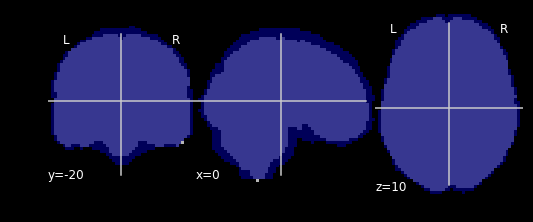

In [41]:
#plot average brain
t1_file = anat_fmriprep_dir + sub + '_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
print(t1_file)
t1_img = image.load_img(t1_file)
t1_img = resample_to_img(t1_img, template)
if ipynby==1:
    plot_roi(avg_mask, bg_img=t1_img)

output_name_mask = mask_fold + '%s_%s_brain.nii.gz' % (sub, ses)
print(output_name_mask)# Save the mask
hdr = avg_mask.header  # get a handle for the .nii file's header
hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
nib.save(avg_mask, output_name_mask)

## Perform spatial smoothing <a id="load_fmri"></a>

In [42]:
#function for smoothing
def mod_smooth(in_file, mask_file, fwhm, smooth_type):
    import nipype.interfaces.fsl as fsl
    import nipype.interfaces.freesurfer as fs
    import os
    if smooth_type == 'susan':
        if fwhm == 0:
            return in_file
        smooth = create_susan_smooth()
        smooth.base_dir = out_dir#os.getcwd()
        smooth.inputs.inputnode.fwhm = fwhm
        smooth.inputs.inputnode.mask_file = mask_file
        smooth.inputs.inputnode.in_files = in_file
        #smooth.outputs.outputnode.smoothed_files='/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-02/ses-01/sub-02_ses-01_task-view_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3TRs_smooth.nii.gz'
        res = smooth.run()
        smoothed_file=[] #smoothed_file = res.outputs.outputnode.smoothed_files
    return smoothed_file

In [43]:
#Load data, resample to 3 mm, truncate, and smooth
epi_trunc=[]
#source below:
#https://github.com/INCF/BrainImagingPipelines/blob/master/bips/workflows/gablab/wips/scripts/modular_nodes.py
print('Number of runs to concatenate:', n_runs_view)

for run in range(firstrun,lastrun+1):#lastrun+1
    out_smooth=(out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval))
    if os.path.exists(out_smooth): #If the file exists, skip this step
        proceeeeed=[]

        epi_data=nib.load(out_smooth)
        epi_data=resample_to_img(epi_data, template)# JWA, August 25 change
        epi=epi_data.get_fdata()

        #truncate
        epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc))
        epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc:]

        print(epi_data.shape, '  ', epi_trunc.shape)
        dimsize=epi_data.header.get_zooms()
        #print(dimsize)
        orig_dimsize=dimsize

        affine_mat = epi_data.affine  # What is the orientation of the data
        print(affine_mat)
    else:
        epi_file=ses1_dir + sub + '_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % run
        epi_data=nib.load(epi_file)
        epi_data=resample_to_img(epi_data, template)# JWA, August 25 change
        epi=epi_data.get_fdata()

        #truncate
        epi_trunc =np.zeros((epi_data.shape[0], epi_data.shape[1], epi_data.shape[2], epi_data.shape[3]-n_trunc))
        epi_trunc[:, :, :, :] = epi[:,:,:,n_trunc:]

        print(epi_data.shape, '  ', epi_trunc.shape)
        dimsize=epi_data.header.get_zooms()
        #print(dimsize)
        orig_dimsize=dimsize

        affine_mat = epi_data.affine  # What is the orientation of the data
        print(affine_mat)

        # Save the volume
        output_name = (out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%dTRs.nii.gz' % (sub, run, n_trunc))

        bold_nii = nib.Nifti1Image(epi_trunc, affine_mat)
        hdr = bold_nii.header  # get a handle for the .nii file's header
        hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2], dimsize[3]))
        nib.save(bold_nii, output_name)

        # smooth with susan 
        smoothed_file = mod_smooth(output_name,output_name_mask,fwhmval, 'susan')

        #move file
        in_smooth=(out_dir+'susan_smooth/smooth/mapflow/_smooth0/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%dTRs_smooth.nii.gz' % (sub, run, n_trunc))
        out_smooth=(out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval))
        os.rename(in_smooth,out_smooth)

Number of runs to concatenate: 3
(61, 73, 61, 1242)    (61, 73, 61, 1239)
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
(61, 73, 61, 1224)    (61, 73, 61, 1221)
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
(61, 73, 61, 1277)    (61, 73, 61, 1274)
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]


## Load smoothed fMRI data, apply mask, filter, z-score, and regress out confounds <a id="load_fmri"></a>

#### Get voxels from an ROI

We will extract BOLD data, only for voxels in a mask, by executing the following sequence of steps: 
1. load whole brain fMRI data (for a given subject and a given run)
2. load the desired mask
3. use `NiftiMasker` to sub-select mask voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

In [44]:
epi_mask_data_all=[]

#Load the fMRI data 
for run in range(firstrun,lastrun+1):
    print('now on run:', run)
    epi_masker= NiftiMasker(mask_img=avg_mask,  high_pass=1/filtcutoff, #high pass filter
        standardize=True,  # Are you going to zscore the data across time? 
        t_r=ss_TR, 
        memory='nilearn_cache',  # Caches the mask in the directory given as a string here so that it is easier to load and retrieve
        memory_level=1,  # How much memory will you cache?
        verbose=0)

    # load data and regress out confounds
    epi_file=out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_smooth%d.nii.gz' % (sub, run, n_trunc,fwhmval)
    confound_file= bold_dir + 'sub-%s_ses-01_task-view_run-%s_desc-confounds_regressors.tsv' %(sub,run)
    if run==firstrun:
        if 0==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[0:int(sum(ntr[run])),:]) #commented from Lizzie
        if 1==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[0:int(sum(ntr[run-1])),:]) #commented from Lizzie
        epi_mask_data_all=epi_mask_data
        nTR_all=epi_mask_data.shape[0]
    else:
        if 0==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[int(sum(ntr[0:run])):int(sum(ntr[0:run+1])),:])
        if 1==firstrun:
            epi_mask_data = epi_masker.fit_transform(epi_file,confounds=confounds_all[int(sum(ntr[0:run-1])):int(sum(ntr[0:run])),:])
        epi_mask_data_all=np.vstack([epi_mask_data_all,epi_mask_data])
        nTR_all=np.vstack([nTR_all,epi_mask_data.shape[0]])
        
    # Save volume
    print('Saving trimmed and normalized volume for run',run)
    
    affine_mat = avg_mask.affine #should be the same as the epi data
    avg_mask.shape
    coords = np.where(avg_mask.get_fdata())
    bold_vol=[]
    bold_vol=np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_data.shape[0]))
    bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_data.T
    print('epi_mask_data shape:', bold_vol.shape)
    
    output_name = (out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_norm.nii.gz' % (sub, run, n_trunc))
    
    bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
    hdr = bold_nii.header  # get a handle for the .nii file's header
    hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
    nib.save(bold_nii, output_name)
        
print(epi_mask_data_all.shape)

#some basics about dimensions
avg_mask.shape
coords = np.where(avg_mask.get_fdata())
print(avg_mask)
dimsize=avg_mask.header.get_zooms()
print(dimsize)
affine_mat = avg_mask.affine  # orientation of the data

now on run: 1
Saving trimmed and normalized volume for run 1
epi_mask_data shape: (61, 73, 61, 1242)
now on run: 2
Saving trimmed and normalized volume for run 2
epi_mask_data shape: (61, 73, 61, 1224)
now on run: 3
Saving trimmed and normalized volume for run 3
epi_mask_data shape: (61, 73, 61, 1277)
(3743, 79117)
<class 'nibabel.nifti1.Nifti1Image'>
data shape (61, 73, 61)
affine: 
[[   3.    0.    0.  -90.]
 [   0.    3.    0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 3 61 73 61  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 3. 3. 3. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
s

## Re-align data in a standardized order <a id="load_fmri"></a>

In [45]:
#load epi_mask_hrf & epi_mask_event matrices with data in a standardize order
#and also save relevant variables for later on

#pre-assign main arrays in which data will go
epi_mask_hrf=np.zeros((d_fl[8,1], epi_mask_data_all.shape[1]))
epi_mask_event=np.zeros((event_fl[8,1], epi_mask_data_all.shape[1]))
confounds_hrf=np.zeros((d_fl[8,1], confounds_all.shape[1])) #save confounds for later
confounds_event=np.zeros((event_fl[8,1], confounds_all.shape[1]))
signed_hrf=np.zeros((d_fl[8,1],1)) # used later on for "signed" surprise
signed_event=np.zeros((event_fl[8,1],1))
run_hrf=np.zeros((d_fl[8,1],1)) # keep track of run #
run_event=np.zeros((event_fl[8,1],1))
print(epi_mask_hrf.shape)
print(epi_mask_event.shape)
print(confounds_all.shape)
print(signed_hrf.shape)

# re-order concatenated volumes
for game in range(ss_tngs):
    #identify game in the order it was shown
    g_num=g_o[0,game]
    pref_ind=pref[0,game] # subject preferred team to win
    slen=event_fl[g_num-1][1]-event_fl[g_num-1][0]+1
    seg=np.arange(MSTR[game,0]+startcut-1,MSTR[game,0]+startcut+slen-1,1)
    seg=seg+hrshiftval #shift for hrf
    slen_d=d_fl[g_num-1][1]-d_fl[g_num-1][0]+1
    seg_d=np.arange(MSTR[game,0]+startcut-1,MSTR[game,0]+startcut+slen_d-1,1)
    #determine which run it was in
    run=np.ceil((game+1)/3)
    if firstrun==1: #most subjects
        if run==2:
            seg=seg+nTR_all[0]
            seg_d=seg_d+nTR_all[0]
        if run==3:
            seg=seg+nTR_all[0]+nTR_all[1]
            seg_d=seg_d+nTR_all[0]+nTR_all[1]
    else: # subjects 4 and 5
        if game==0:
            run=0
        if run==1:
            seg=seg+nTR_all[0]
            seg_d=seg_d+nTR_all[0]
        if run==2:
            seg=seg+nTR_all[0]+nTR_all[1]
            seg_d=seg_d+nTR_all[0]+nTR_all[1]
        if run==3:
            seg=seg+nTR_all[0]+nTR_all[1]+nTR_all[2]
            seg_d=seg_d+nTR_all[0]+nTR_all[1]+nTR_all[2]
        
    epi_mask_hrf[d_fl[g_num-1][0]-1:d_fl[g_num-1][1],:]=epi_mask_data_all[seg_d.astype(int),:]
    epi_mask_event[event_fl[g_num-1][0]-1:event_fl[g_num-1][1],:]=epi_mask_data_all[seg.astype(int),:]
    confounds_hrf[d_fl[g_num-1][0]-1:d_fl[g_num-1][1],:]=confounds_all[seg_d.astype(int),:]
    confounds_event[event_fl[g_num-1][0]-1:event_fl[g_num-1][1],:]=confounds_all[seg.astype(int),:]
    run_hrf[d_fl[g_num-1][0]-1:d_fl[g_num-1][1],:]=run
    run_event[event_fl[g_num-1][0]-1:event_fl[g_num-1][1],:]=run
    #assign signed variable based on preferred winner
    if pref_ind==1:
        signed_hrf[d_fl[g_num-1][0]-1:d_fl[g_num-1][1],:]=1
        signed_event[event_fl[g_num-1][0]-1:event_fl[g_num-1][1],:]=1
    if pref_ind==3:
        signed_hrf[d_fl[g_num-1][0]-1:d_fl[g_num-1][1],:]=-1
        signed_event[event_fl[g_num-1][0]-1:event_fl[g_num-1][1],:]=-1 

(3426, 79117)
(3408, 79117)
(3743, 13)
(3426, 1)


In [46]:
# check out some other variables
print(MSTR[game,0])
print(nTR_all[0]+nTR_all[1])
print(seg_d)
print(slen_d)

910.0
[2466]
[3385. 3386. 3387. 3388. 3389. 3390. 3391. 3392. 3393. 3394. 3395. 3396.
 3397. 3398. 3399. 3400. 3401. 3402. 3403. 3404. 3405. 3406. 3407. 3408.
 3409. 3410. 3411. 3412. 3413. 3414. 3415. 3416. 3417. 3418. 3419. 3420.
 3421. 3422. 3423. 3424. 3425. 3426. 3427. 3428. 3429. 3430. 3431. 3432.
 3433. 3434. 3435. 3436. 3437. 3438. 3439. 3440. 3441. 3442. 3443. 3444.
 3445. 3446. 3447. 3448. 3449. 3450. 3451. 3452. 3453. 3454. 3455. 3456.
 3457. 3458. 3459. 3460. 3461. 3462. 3463. 3464. 3465. 3466. 3467. 3468.
 3469. 3470. 3471. 3472. 3473. 3474. 3475. 3476. 3477. 3478. 3479. 3480.
 3481. 3482. 3483. 3484. 3485. 3486. 3487. 3488. 3489. 3490. 3491. 3492.
 3493. 3494. 3495. 3496. 3497. 3498. 3499. 3500. 3501. 3502. 3503. 3504.
 3505. 3506. 3507. 3508. 3509. 3510. 3511. 3512. 3513. 3514. 3515. 3516.
 3517. 3518. 3519. 3520. 3521. 3522. 3523. 3524. 3525. 3526. 3527. 3528.
 3529. 3530. 3531. 3532. 3533. 3534. 3535. 3536. 3537. 3538. 3539. 3540.
 3541. 3542. 3543. 3544. 3545. 3546. 3

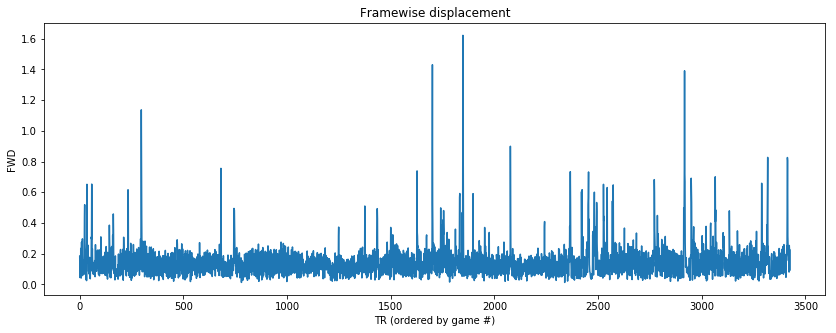

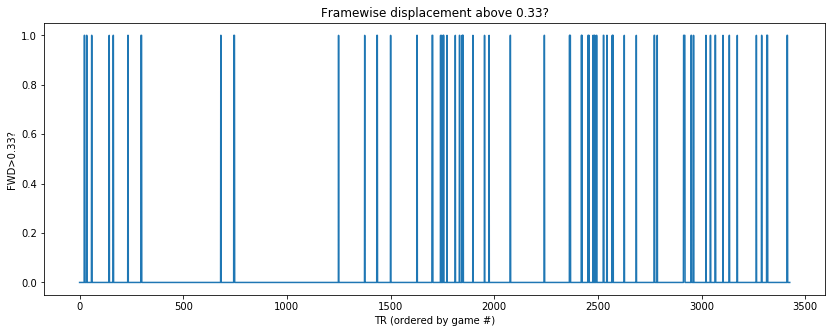

In [47]:
#apply frame-wise displacement threshold and create related variables 
fwdthresh=0.33
fwdhigh_hrf=np.zeros((d_fl[8,1],1))
for tr in range(1,d_fl[8,1]):
    if confounds_hrf[tr,6]>fwdthresh:
        fwdhigh_hrf[tr]=1
fwdhigh_event=np.zeros((event_fl[8,1],1))
for tr in range(1,event_fl[8,1]):
    if confounds_event[tr,6]>fwdthresh:
        fwdhigh_event[tr]=1

if ipynby==1: #plot these results
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(confounds_hrf[:,6])
    ax.set_title('Framewise displacement')
    ax.set_xlabel('TR (ordered by game #)')
    ax.set_ylabel('FWD')
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(fwdhigh_hrf)
    ax.set_title('Framewise displacement above %s?' %fwdthresh)
    ax.set_xlabel('TR (ordered by game #)')
    ax.set_ylabel('FWD>%s?' %fwdthresh)

In [48]:
#append frame-wise displacement variable to confound regressors
print(confounds_hrf.shape)
confounds_hrf=np.hstack([confounds_hrf,run_hrf])
confounds_hrf=np.hstack([confounds_hrf,fwdhigh_hrf])
print(confounds_hrf.shape)
print(confounds_event.shape)
confounds_event=np.hstack([confounds_event,run_event])
confounds_event=np.hstack([confounds_event,fwdhigh_event])
print(confounds_event.shape)
#Was previously Z-scoring here, but changed to doing it at input
epi_mask_hrf2=epi_mask_hrf
epi_mask_event2=epi_mask_event
#epi_mask_hrf2=stats.zscore(epi_mask_hrf,axis=0)
#epi_mask_event2=stats.zscore(epi_mask_event,axis=0)
print(epi_mask_hrf2.shape)

(3426, 13)
(3426, 15)
(3408, 13)
(3408, 15)
(3426, 79117)


(3426, 15)
(3426, 15)


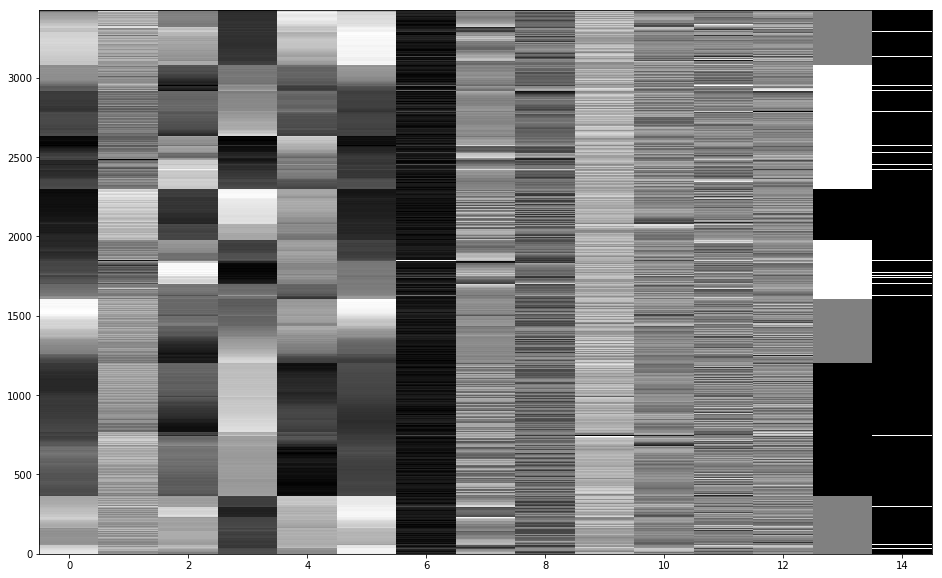

In [49]:
#rescale regressors
def rescale(x):
    tmin=np.min(x)
    tmax=np.max(x)
    trange=tmax-tmin
    tmid=tmin+trange/2
    x=(x-tmid)/(trange/2)
    return x

confounds_hrf2=[]
confounds_hrf2=np.zeros((confounds_hrf.shape[0],confounds_hrf.shape[1]))
for confound in range(0,confounds_hrf.shape[1]):
    confounds_hrf2[:,confound]=rescale(confounds_hrf[:,confound])
print(confounds_hrf.shape)
print(confounds_hrf2.shape)

#save confounds_hrf2 as .mat
#mat_fname=nonfmri_dir+'confounds_hrf3_%s.mat' %hrshiftval
mat_fname=nonfmri_dir+'confounds_hrf2_%s.mat' %hrshiftval
scipy.io.savemat(mat_fname,{'confounds_hrf2': confounds_hrf2,'confounds_hrf': confounds_hrf,
                            'fwdhigh_hrf': fwdhigh_hrf,'nTR_all': nTR_all,
                            'signed_hrf': signed_hrf,'signed_event': signed_event,
                           'confounds_event': confounds_event,'fwdhigh_event': fwdhigh_event})

if ipynby==1: # plot confidence matrix
    plt.figure(figsize=(16,10))
    this_img = confounds_hrf2; 
    plt.imshow(this_img,cmap='gray',origin='lower',interpolation='none',aspect="auto")

In [50]:
# prepare volumes to save
bold_vol=np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_hrf2.shape[0]))
bold_vol[coords[0], coords[1], coords[2], :] = epi_mask_hrf2.T
bold_vol_event=np.zeros((avg_mask.shape[0], avg_mask.shape[1], avg_mask.shape[2], epi_mask_event2.shape[0]))
bold_vol_event[coords[0], coords[1], coords[2], :] = epi_mask_event2.T
print(bold_vol.shape)
print(bold_vol_event.shape)
print(avg_mask.shape)

(61, 73, 61, 3426)
(61, 73, 61, 3408)
(61, 73, 61)


In [51]:
# Save the concatenated volumes, both glm and event files
output_name = out_dir + '%s_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_%s_%s_norm_glm.nii.gz' % (sub, n_trunc,hrshiftval,filtcutoff)
print(output_name)
bold_nii = nib.Nifti1Image(bold_vol, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
print(orig_dimsize)
hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
nib.save(bold_nii, output_name)
print('Volume saved')
#event file
output_name = out_dir + '%s_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_%s_%s_norm_event.nii.gz' % (sub, n_trunc,hrshiftval,filtcutoff)
print(output_name)
bold_nii = nib.Nifti1Image(bold_vol_event, affine_mat)
hdr = bold_nii.header  # get a handle for the .nii file's header
print(orig_dimsize)
hdr.set_zooms((orig_dimsize[0], orig_dimsize[1], orig_dimsize[2], orig_dimsize[3]))
nib.save(bold_nii, output_name)
print('Volume saved')
endtime = time.time()
print(endtime - starttime)

/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-01/sub-01_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3_5_128_norm_glm.nii.gz
(3.0, 3.0, 3.0, 1.0)
Volume saved
/jukebox/norman/jantony/surprisesuspense/data/bids/Norman/Antony/ss/derivatives/firstlevel/sub-01/sub-01_task-view_space-MNI152NLin2009cAsym_desc-preproc_bold_trim3_5_128_norm_event.nii.gz
(3.0, 3.0, 3.0, 1.0)
Volume saved
482.903208732605


# Visualizations
## Plot voxels across runs in game order

In [ ]:
#estimate autocorrelation - not currently used
'''
def estimated_autocorrelation(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

voxel_id=17891
a1=estimated_autocorrelation(epi_mask_hrf2[:, voxel_id])
print(a1.shape)
pts=20
if ipynby==1:
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(a1[0:pts])'''

In [ ]:
#here are some plots visualizing the data. nothing else is saved after this.
if ipynby==1:
    n_vox=20000
    plt.figure(figsize=(10,16))
    this_img = epi_mask_hrf2[:,:n_vox]; 
    this_img=this_img.T;#must transform because of how Python reshapes
    tn='HRF-%s' %sub;
    plt.imshow(this_img,cmap='gray',origin='lower',interpolation='none',aspect="auto")
    plt.title(tn)

In [ ]:
if ipynby==1:
    for run in range(1,n_runs_view+1):
        func_name=out_dir + 'ses-01/' + '%s_ses-01_task-view_run-0%i_space-MNI152NLin2009cAsym_desc-preproc_bold_trim%d_norm.nii.gz' % (sub, run, n_trunc)

        #print(image.load_img(func_name).shape)
        vol_num=round(image.load_img(func_name).shape[3]/2)
        middle_vol = image.index_img(func_name,vol_num)
        #mean_func = mean_img(func_name)
        print('Plotting middle volumed for run',run)
        plot_epi(middle_vol)

## Plot a voxel time-series <a id="plot_voxel"></a>

In [ ]:
# Plot value of voxel_id through time 
if ipynby==1:
    voxel_id = 2000
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(epi_mask_hrf[0:200, voxel_id])
    ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
    ax.set_xlabel('TR (ordered by game #)')
    ax.set_ylabel('Voxel Intensity')
    f, ax = plt.subplots(1,1, figsize=(14,5))
    ax.plot(epi_mask_hrf2[0:200, voxel_id])
    ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
    ax.set_xlabel('TR (ordered by game #)')
    ax.set_ylabel('Voxel Intensity-normed')

## Check mean and standard deviation of normalized data 

In [ ]:
#If the data are Z-scored, these should obviously look very standardized.
if ipynby==1:
    x_mean = np.mean(epi_mask_hrf2, axis=0)
    x_std = np.std(epi_mask_hrf2, axis=0, dtype=np.float64)
    print('mean of 1st few time points:\n', x_mean[0:50])
    print('')
    print('std of 1st few time points:\n', x_std[0:50])
    print('')
    print(np.shape(x_mean))
    print(np.shape(x_std))
    print('')
    print(np.amin(x_mean), np.amax(x_mean))
    print(np.amin(x_std), np.amax(x_std))
    # print(x_std)

    f, axes = plt.subplots(1, 2, figsize = (14,4))
    n_bins = 20
    axes[0].hist(x_mean, bins = n_bins)
    axes[0].set_title('distribution of means')
    axes[0].set_xlabel('mean values')
    axes[0].set_ylabel('counts')
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1].hist(x_std, bins = n_bins)
    axes[1].set_title('distribution of stds')
    axes[1].set_xlabel('std values')
    axes[1].set_ylabel('counts')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
    axes[1].get_xaxis().get_major_formatter().set_useOffset(False)
    plt.show()